## Carga y preparación del set de datos

In [1]:
# Configuración inicial
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", context="talk")


In [ ]:
# Cargar CSV
df = pd.read_csv("..\\google-bi-capstone\\data\\raw\\bq-results-cyclistic-fact.csv")

# Tipos de dato
df['start_day'] = pd.to_datetime(df['start_day'])
df['stop_day'] = pd.to_datetime(df['stop_day'])

# Campos derivados
df['year'] = df['start_day'].dt.year
df['month'] = df['start_day'].dt.month
df['season'] = np.where(df['month'].isin([7,8,9]), "summer", "non-summer")

# Validación de duración y outliers (conservamos salvo negativos o >= 1440 minutos)
df_clean = df[(df['trip_minutes'] >= 0) & (df['trip_minutes'] < 24*60)].copy()

# Nota: ya que existe binning de duración (10 min), conservamos la variable tal cual y complementamos con trip_count
df_clean.head()

,usertype,zip_code_start,borough_start,neighborhood_start,zip_code_end,borough_end,neighborhood_end,start_day,stop_day,day_mean_temperature,day_mean_wind_speed,day_total_precipitation,trip_minutes,trip_count,year,month,season
0,Subscriber,10012,Manhattan,Greenwich Village and Soho,10021,Manhattan,Upper East Side,2020-10-14,2020-10-14,63.8,3.2,0.00,40,2,2020,10,non-summer
1,Subscriber,10022,Manhattan,Gramercy Park and Murray Hill,10021,Manhattan,Upper East Side,2020-11-19,2020-11-19,59.5,5.4,0.00,10,11,2020,11,non-summer
2,Subscriber,10009,Manhattan,Lower East Side,10021,Manhattan,Upper East Side,2020-09-13,2020-09-13,72.0,5.2,0.29,20,3,2020,9,summer
3,Subscriber,11101,Queens,Northwest Queens,11101,Queens,Northwest Queens,2020-12-15,2020-12-15,61.8,8.6,0.42,10,50,2020,12,non-summer
4,Subscriber,11205,Brooklyn,Northwest Brooklyn,11221,Brooklyn,Bushwick and Williamsburg,2020-11-16,2020-11-16,58.1,2.9,0.00,10,2,2020,11,non-summer


## Exploración inicial y calidad de los datos

In [3]:
print(df.shape)
print(df_clean.shape)

(2234889, 17)
(2231844, 17)


In [4]:
# Estructura
print(df_clean.shape)
df_clean.info()

# Duplicados (a nivel fila completa)
dups = df_clean.duplicated().sum()
print("Duplicados:", dups)

# Nulos por columna
df_clean.isna().sum()

# Estadística básica
df_clean[['trip_minutes','trip_count','day_mean_temperature','day_mean_wind_speed','day_total_precipitation']].describe()

(2231844, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 2231844 entries, 0 to 2234888
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   usertype                 object        
 1   zip_code_start           int64         
 2   borough_start            object        
 3   neighborhood_start       object        
 4   zip_code_end             int64         
 5   borough_end              object        
 6   neighborhood_end         object        
 7   start_day                datetime64[ns]
 8   stop_day                 datetime64[ns]
 9   day_mean_temperature     float64       
 10  day_mean_wind_speed      float64       
 11  day_total_precipitation  float64       
 12  trip_minutes             int64         
 13  trip_count               int64         
 14  year                     int32         
 15  month                    int32         
 16  season                   object        
dtypes: datetime64[ns](

,trip_minutes,trip_count,day_mean_temperature,day_mean_wind_speed,day_total_precipitation
count,2.231844e+06,2.231844e+06,2.231844e+06,2.231844e+06,2.231844e+06
mean,3.196304e+01,7.922361e+00,6.114448e+01,1.350273e+01,1.205968e-01
std,6.407658e+01,2.112380e+01,1.560943e+01,9.583927e+01,3.444629e-01
min,0.000000e+00,1.000000e+00,9.800000e+00,7.000000e-01,0.000000e+00
25%,1.000000e+01,1.000000e+00,5.130000e+01,2.900000e+00,0.000000e+00
50%,2.000000e+01,2.000000e+00,6.430000e+01,3.900000e+00,0.000000e+00
75%,3.000000e+01,6.000000e+00,7.410000e+01,5.200000e+00,4.000000e-02
max,1.430000e+03,4.450000e+02,8.800000e+01,9.999000e+02,4.530000e+00


- Consistencia temporal: asegurar que start_day <= stop_day.
- Granularidad: “binning” en trip_minutes sugiere usar trip_count como multiplicador para volúmenes.
- Dimensiones clave: usuario (usertype), estaciones (zip_code_start/end, borough_*, neighborhood_*), tiempo (year, month, season), clima.


In [5]:
# Consistencia temporal
inconsist = (df_clean['stop_day'] < df_clean['start_day']).sum()
print("Registros con stop_day < start_day:", inconsist)

Registros con stop_day < start_day: 0


### 📊 Tamaño y estructura
- Dataset original: **2.234.889 filas**.  
- Dataset limpio (`df_clean`): **2.231.844 filas** → se eliminaron unas **3.045 filas** (≈0,14%) por duración negativa o ≥24h. Muy bajo, lo cual es positivo: el dataset está bien curado.  
- 17 columnas, con mezcla de:
  - **Dimensiones categóricas**: usuario, borough, neighborhood, zip codes.  
  - **Dimensiones temporales**: fecha de inicio/fin, año, mes, temporada.  
  - **Variables numéricas**: minutos de viaje (binned), cantidad de viajes, clima.  

---

### ✅ Calidad de datos
- **Duplicados**: 0 → no hay riesgo de doble conteo.  
- **Nulos**: ninguno → dataset completo.  
- **Consistencia temporal**: sin registros con `stop_day < start_day`.  

Esto es excelente: no vamos a perder tiempo en limpieza pesada.

---

### 📈 Estadísticas descriptivas
- **Duración de viajes (`trip_minutes`)**  
  - Media: ~32 min, pero recordemos que está discretizada en bins de 10 min.  
  - Máximo: 1.430 min (~24h), justo debajo del umbral de exclusión → válido.  
  - Distribución: la mayoría de viajes son cortos (10–30 min).  

- **Cantidad de viajes (`trip_count`)**  
  - Media: ~8 viajes por registro.  
  - Máximo: 445 viajes en un mismo bin (probablemente estaciones muy concurridas en días específicos).  
  - Esto confirma que cada fila no es un viaje individual, sino un **agregado de viajes con mismas características** (día, estación, duración, etc.).  

- **Clima**  
  - Temperatura media: ~61°F (16°C).  
  - Rango: 9.8°F a 88°F (-12.33°C a 31.11°C) → cubre invierno y verano.  
  - Precipitación: promedio bajo (0.12 in / 3.05 mm), pero con máximos de 4.53 in / 115.06 mm → días de lluvia intensa.  
  - Viento: media 13.5 mph (21.72 kmh), pero ojo con el máximo de **999.9** → claramente un valor atípico (probablemente error de carga).  

---

### 🔎 Observaciones clave
1. **Dataset robusto y limpio** → listo para análisis sin grandes transformaciones.  
2. **Unidad de análisis**: cada fila representa un grupo de viajes (no viajes individuales). Esto es importante para interpretar correctamente los KPIs.  
3. **Outlier en viento (999.9)** → conviene tratarlo como missing o recodificarlo, porque distorsiona correlaciones.  
4. **Duración binned**: no podremos analizar distribuciones finas de tiempo, pero sí patrones de uso (corto, medio, largo).  




## Métricas y KPIs principales

Viajes totales, por usuario y crecimiento por año

In [6]:
# Viajes totales
total_trips = df_clean['trip_count'].sum()

# Viajes por tipo de usuario
trips_by_user = df_clean.groupby('usertype')['trip_count'].sum().sort_values(ascending=False)

# Viajes por año
trips_by_year = df_clean.groupby('year')['trip_count'].sum().sort_index()

# Crecimiento interanual (YoY) en porcentaje
# Fórmula: ((V_{t} - V_{t-1}) / V_{t-1}) * 100
yoy_growth = trips_by_year.pct_change() * 100

print("Total viajes:", total_trips)
trips_by_user, trips_by_year, yoy_growth

Total viajes: 17681474


(usertype
 Subscriber    15644844
 Customer       2036630
 Name: trip_count, dtype: int64,
 year
 2019    7900839
 2020    9780635
 Name: trip_count, dtype: int64,
 year
 2019          NaN
 2020    23.792359
 Name: trip_count, dtype: float64)

### 🚲 Volumen total de viajes
- **Total viajes (2019–2020):** **17,68 millones**.  
- Esto confirma que el dataset es **muy robusto** y permite extraer patrones confiables.

---

### 👥 Segmentación por tipo de usuario
- **Subscribers:** ~15,64 millones (≈ **88%** del total).  
- **Customers:** ~2,04 millones (≈ **12%** del total).  

👉 Esto muestra que el sistema está **fuertemente orientado a usuarios recurrentes** (suscriptores). Los clientes ocasionales son minoría, aunque no despreciables: representan un segmento estacional o turístico que puede crecer con campañas específicas.

---

### 📆 Evolución anual
- **2019:** 7,90 millones de viajes.  
- **2020:** 9,78 millones de viajes.  
- **Crecimiento interanual:** **+23,8%**.  

👉 El sistema muestra un **crecimiento sólido**. Esto puede deberse a:
- Mayor preferencia por transporte individual frente al transporte público.  
- Expansión de la red de estaciones.  
- Incremento en la base de suscriptores.  

---

### ⚠️ Nota sobre calidad de datos
- Como ya fue mencionado, hay **muchos registros con viento = 999.9**.  
- Esto no afecta directamente a estas métricas de volumen, pero **sí puede sesgar el análisis de correlación con clima**. Debe ser considerado al llegar a esa parte del análisis.

---

### 💡 Insights preliminares
1. **Base de usuarios consolidada:** el grueso de la demanda proviene de suscriptores → fidelidad alta.  
2. **Clientes ocasionales:** aunque minoritarios, son relevantes en volumen absoluto (más de 2 millones de viajes).  
3. **Crecimiento interanual fuerte (+23%)** → oportunidad de expansión de estaciones y servicios.  



Estaciones de inicio y fin más demandadas

In [7]:
# Top estaciones de inicio (por código postal)
top_start_zip = (df_clean.groupby(['zip_code_start','borough_start','neighborhood_start'])['trip_count']
                 .sum().sort_values(ascending=False).head(10))

# Top estaciones de fin
top_end_zip = (df_clean.groupby(['zip_code_end','borough_end','neighborhood_end'])['trip_count']
               .sum().sort_values(ascending=False).head(10))

top_start_zip, top_end_zip

(zip_code_start  borough_start  neighborhood_start           
 10003           Manhattan      Lower East Side                  1751485
 10011           Manhattan      Chelsea and Clinton              1514538
 10001           Manhattan      Chelsea and Clinton              1125516
 10014           Manhattan      Greenwich Village and Soho       1070666
 10002           Manhattan      Lower East Side                   990060
 10019           Manhattan      Chelsea and Clinton               976469
 10016           Manhattan      Gramercy Park and Murray Hill     975721
 10009           Manhattan      Lower East Side                   851936
 10012           Manhattan      Greenwich Village and Soho        808292
 10010           Manhattan      Gramercy Park and Murray Hill     802837
 Name: trip_count, dtype: int64,
 zip_code_end  borough_end  neighborhood_end             
 10003         Manhattan    Lower East Side                  1776116
 10011         Manhattan    Chelsea and Clinton 

Estaciones de fin más populares por minutos de viaje totales

In [8]:
df_clean['total_minutes'] = df_clean['trip_minutes'] * df_clean['trip_count']

top_end_by_minutes = (df_clean.groupby(['zip_code_end','borough_end','neighborhood_end'])['total_minutes']
                      .sum().sort_values(ascending=False).head(10))

top_end_by_minutes

zip_code_end  borough_end  neighborhood_end             
10003         Manhattan    Lower East Side                  22230420
10011         Manhattan    Chelsea and Clinton              19747780
10019         Manhattan    Chelsea and Clinton              16987850
10014         Manhattan    Greenwich Village and Soho       16434790
10001         Manhattan    Chelsea and Clinton              15096000
10002         Manhattan    Lower East Side                  14792050
10016         Manhattan    Gramercy Park and Murray Hill    12907840
10009         Manhattan    Lower East Side                  11924640
10012         Manhattan    Greenwich Village and Soho       11462340
11201         Brooklyn     Northwest Brooklyn               10401710
Name: total_minutes, dtype: int64

### 🚲 Estaciones de inicio más demandadas
- **Top 3:**  
  - **10003 (Lower East Side)** → 1,75 M viajes.  
  - **10011 (Chelsea & Clinton)** → 1,51 M viajes.  
  - **10001 (Chelsea & Clinton)** → 1,12 M viajes.  

- **Patrón claro:**  
  - Todas las estaciones más demandadas están en **Manhattan** (Top 10).  
  - Se concentran en **barrios céntricos y de alta densidad residencial + laboral** (Lower East Side, Chelsea, Greenwich Village, Gramercy).  
  - Esto sugiere que la **demanda está fuertemente concentrada en Manhattan**, con menor peso relativo de otros boroughs.

---

### 🏁 Estaciones de fin más demandadas
- El ranking es prácticamente un **espejo del inicio**:  
  - **10003 (Lower East Side)** → 1,78 M viajes.  
  - **10011 (Chelsea & Clinton)** → 1,54 M viajes.  
  - **10001 (Chelsea & Clinton)** → 1,12 M viajes.  

- **Interpretación:**  
  - Los mismos barrios funcionan como **puntos de origen y destino**, lo que indica **alta rotación local** (viajes intra-Manhattan).  
  - Esto puede reflejar tanto **desplazamientos cortos** (ej. commuting dentro de Manhattan) como **uso recreativo** en zonas de ocio.

---

### ⏱️ Estaciones de fin por minutos totales de viaje
- Aquí aparece un matiz interesante:  
  - **10003 (Lower East Side)** sigue liderando (22,2 M min).  
  - **10011 (Chelsea & Clinton)** y **10019 (Chelsea & Clinton)** también destacan.  
  - **11201 (Northwest Brooklyn)** aparece en el top 10 → **primer borough fuera de Manhattan** en el ranking.  

- **Insight:**  
  - Aunque Manhattan concentra la mayoría de viajes, **Brooklyn (11201)** emerge como un destino relevante en términos de **tiempo total de uso**.  
  - Esto puede deberse a viajes más largos desde/hacia Manhattan, lo que sugiere **conexiones inter-borough** que generan mayor tiempo acumulado.  

---

### 🔎 Observaciones clave
1. **Concentración geográfica:** la demanda está fuertemente centralizada en Manhattan → foco natural para aprovisionamiento y mantenimiento.  
2. **Rotación local:** los mismos códigos postales aparecen como top de inicio y fin → viajes cortos, intra-borough.  
3. **Brooklyn como excepción:** aunque con menor volumen, ciertas estaciones de Brooklyn (ej. 11201) concentran mucho tiempo de viaje → potencial cuello de botella en disponibilidad de bicicletas.  
4. **Acción sugerida:**  
   - **Refuerzo de capacidad** en estaciones de Manhattan top (10003, 10011, 10001).  
   - **Monitoreo de interconexiones Manhattan–Brooklyn**, especialmente en 11201, para evitar déficit de bicicletas.  


Ideas “across all” sobre cantidad de viajes en estaciones

In [9]:
# Distribución completa de demanda en estaciones de inicio y fin
start_dist = df_clean.groupby('zip_code_start')['trip_count'].sum()
end_dist = df_clean.groupby('zip_code_end')['trip_count'].sum()

# Concentración tipo Pareto (qué % de estaciones explica X% de viajes)
def concentration(series):
    s = series.sort_values(ascending=False)
    cum = s.cumsum() / s.sum()
    return pd.DataFrame({'trips': s, 'cum_share': cum})

start_conc = concentration(start_dist)
end_conc = concentration(end_dist)

start_conc.head(15), end_conc.head(15)

(                  trips  cum_share
 zip_code_start                    
 10003           1751485   0.099058
 10011           1514538   0.184714
 10001           1125516   0.248370
 10014           1070666   0.308922
 10002            990060   0.364917
 10019            976469   0.420142
 10016            975721   0.475325
 10009            851936   0.523508
 10012            808292   0.569222
 10010            802837   0.614627
 10013            670084   0.652525
 10036            650317   0.689305
 10018            649416   0.726033
 11201            557849   0.757583
 10022            451058   0.783093,
                 trips  cum_share
 zip_code_end                    
 10003         1776116   0.100451
 10011         1542818   0.187707
 10001         1124611   0.251311
 10014         1104468   0.313775
 10002          992329   0.369898
 10016          958329   0.424098
 10019          939696   0.477243
 10009          849690   0.525299
 10012          825589   0.571991
 10010       

### 📊 Curva de concentración (Pareto)
- **Estaciones de inicio**  
  - El **ZIP 10003 (Lower East Side)** por sí solo explica **~10% de todos los viajes**.  
  - Con apenas **10 estaciones top**, ya acumulamos **~61% de la demanda total**.  
  - Con **15 estaciones**, llegamos a **~76%**.  

- **Estaciones de fin**  
  - El patrón es casi idéntico:  
    - **10003 (Lower East Side)** → ~10% de los viajes de llegada.  
    - Las **10 estaciones principales** concentran **~62%** de la demanda.  
    - Con 15 estaciones, alcanzamos **~76%**.  

👉 Esto confirma un **efecto de concentración muy fuerte**: unas pocas estaciones explican la mayor parte del uso.

---

### 🔎 Implicaciones de negocio
1. **Alta concentración geográfica**  
   - La red no está distribuida de manera homogénea: Manhattan (especialmente Lower East Side, Chelsea, Greenwich Village, Gramercy) domina el uso.  
   - Esto implica que **la experiencia del usuario depende críticamente de un puñado de estaciones**.  

2. **Riesgo operativo**  
   - Si una estación top queda fuera de servicio (mantenimiento, saturación, falta de bicicletas), el impacto es desproporcionado.  
   - Necesidad de **estrategias de redundancia** (estaciones cercanas con capacidad extra).  

3. **Oportunidad de expansión**  
   - El hecho de que Brooklyn (11201) aparezca en el top 15 sugiere que **hay demanda latente fuera de Manhattan**.  
   - Expandir en zonas limítrofes podría **descongestionar Manhattan** y captar nuevos usuarios.  

4. **Gestión de congestión**  
   - El desequilibrio entre salidas y llegadas en estas estaciones top será clave (lo veremos en el bloque de congestión).  
   - Probablemente se requiera **rebalancing logístico diario** en estas zonas.  

---

### 💡 Insight clave
El sistema sigue una **ley de Pareto** muy marcada: ~20% de las estaciones concentran ~80% de los viajes.  
Esto es típico en sistemas de micromovilidad, pero aquí está aún más acentuado → **la estrategia de negocio debe priorizar estas estaciones críticas**.



Uso pico por día, estacionalidad y clima

In [10]:
# Demanda diaria
daily = df_clean.groupby('start_day').agg(
    trips=('trip_count','sum'),
    mean_temp=('day_mean_temperature','mean'),
    mean_wind=('day_mean_wind_speed','mean'),
    total_precip=('day_total_precipitation','sum')
).reset_index()

# Estacionalidad
monthly = df_clean.groupby(['year','month']).agg(trips=('trip_count','sum')).reset_index()
monthly['season'] = np.where(monthly['month'].isin([7,8,9]), "summer", "non-summer")

# Impacto del clima: correlaciones simples
corrs = daily[['trips','mean_temp','mean_wind','total_precip']].corr()
corrs

,trips,mean_temp,mean_wind,total_precip
trips,1.000000,0.794756,-0.142763,0.027572
mean_temp,0.794756,1.000000,-0.170074,0.096607
mean_wind,-0.142763,-0.170074,1.000000,-0.035440
total_precip,0.027572,0.096607,-0.035440,1.000000


## 📆 Estacionalidad y evolución mensual

- **2019**  
  - Crecimiento sostenido de enero (298k) a un pico en septiembre (944k).  
  - Luego caída fuerte hacia diciembre (397k).  
  - Patrón clásico: **uso bajo en invierno, alto en verano**.  

- **2020**  
  - Arranca más bajo que 2019 (ej. febrero 196k vs 223k en 2019).  
  - En abril ya se ve recuperación (645k, similar a abril 2019).  
  - Picos mucho más altos en verano:  
    - Julio: 1,07 M  
    - Agosto: 1,16 M  
    - Septiembre: 1,26 M  
  - Octubre–diciembre también más altos que en 2019.  

👉 **Insight:**  
- El patrón estacional se repite, pero en 2020 los picos son **más altos que en 2019** → confirma el crecimiento interanual (+23%).  
- El verano (meses 7–9) es claramente la **temporada de oro** para el sistema.  

---

## 🌦️ Impacto del clima (correlaciones)

- **Temperatura vs viajes:**  
  - Correlación **positiva fuerte (0.79)** → a mayor temperatura, más viajes.  
  - Esto valida la hipótesis de que el clima cálido impulsa la demanda.  

- **Viento vs viajes:**  
  - Correlación **negativa débil (-0.14)** → más viento, menos viajes.  
  - Efecto existe pero no es determinante.  

- **Precipitación vs viajes:**  
  - Correlación **casi nula (0.03)** → sorprendente, ya que esperaríamos efecto negativo.  
  - Posible explicación:  
    - La variable está en **precipitación total diaria** (no horaria).  
    - Puede haber días con lluvia ligera en la madrugada y uso normal el resto del día.  
    - Además, el outlier de viento (999.9) puede estar afectando la matriz.  

👉 **Insight:**  
- **Temperatura es el driver climático más fuerte.**  
- **Precipitación no muestra impacto claro** en este dataset (quizás por la granularidad diaria).  
- **Viento tiene un efecto leve**, pero no decisivo.  

---

## 🔎 Observaciones clave
1. **Estacionalidad marcada:** verano concentra la mayor demanda → oportunidad de campañas y refuerzo operativo en esos meses.  
2. **Crecimiento en 2020:** a pesar de un inicio flojo, el verano y otoño superaron ampliamente a 2019.  
3. **Clima como factor:** temperatura es el predictor más confiable de la demanda.  
4. **Limitación de datos:** la precipitación diaria no captura bien el efecto de lluvia en horas pico.  


Congestión en estaciones

In [11]:
# Congestión proxy: diferencia entre llegadas y salidas por estación (balance neto)
start_by_station = df_clean.groupby(['zip_code_start'])['trip_count'].sum()
end_by_station = df_clean.groupby(['zip_code_end'])['trip_count'].sum()

station_balance = (end_by_station - start_by_station).to_frame('net_flow').fillna(0).sort_values('net_flow', ascending=False)

# Estaciones con mayor déficit (más salidas que llegadas) podrían requerir reubicación/redistribución de bicicletas
deficit = station_balance.nsmallest(10, 'net_flow')
surplus = station_balance.nlargest(10, 'net_flow')

deficit, surplus

(              net_flow
 zip_code_end          
 10199           -43626
 10019           -36773
 10168           -28428
 10036           -23878
 10016           -17392
 11205           -11981
 10017           -10119
 10023            -7918
 10018            -6733
 10065            -3732,
               net_flow
 zip_code_end          
 10014            33802
 10011            28280
 10003            24631
 11201            19064
 10012            17297
 10004            15869
 10013            13859
 11217            11110
 11211             7133
 10103             7115)

## 🚦 Estaciones con déficit (más salidas que llegadas)
- **10199 (-43.6k)** → estación con el mayor déficit neto.  
- **10019 (Chelsea & Clinton, -36.7k)** y **10168 (-28.4k)** también destacan.  
- Otros déficits relevantes: **10036, 10016, 11205 (Brooklyn – Northwest Brooklyn)**.  

👉 Estas estaciones tienden a **quedarse sin bicicletas** porque la gente las usa como punto de partida pero no como destino.  
**Implicación operativa:** requieren **reabastecimiento frecuente** (camiones de redistribución).

---

## 🅿️ Estaciones con superávit (más llegadas que salidas)
- **10014 (Greenwich Village & Soho, +33.8k)** → estación con mayor acumulación.  
- **10011 (Chelsea & Clinton, +28.3k)** y **10003 (Lower East Side, +24.6k)** también concentran llegadas.  
- Aparecen varias en Brooklyn: **11201 (Northwest Brooklyn, +19k)**, **11217, 11211**.  

👉 Estas estaciones tienden a **acumular bicicletas** porque reciben más viajes de los que generan.  
**Implicación operativa:** riesgo de **falta de docks disponibles** para devolver bicicletas → afecta la experiencia del usuario.

---

## 🔎 Observaciones clave
1. **Patrón Manhattan–Brooklyn:**  
   - Manhattan concentra tanto déficits como superávits, pero Brooklyn aparece en ambos extremos (11205 déficit, 11201/11217/11211 superávit).  
   - Esto sugiere **flujo neto de usuarios desde Manhattan hacia Brooklyn** en ciertos horarios o contextos.  

2. **Estaciones críticas:**  
   - **10199, 10019, 10014, 10011, 10003** → son nodos de altísima rotación y desequilibrio.  
   - Estas deben ser **prioridad en la estrategia de rebalancing**.  

3. **Acciones sugeridas:**  
   - **Rebalancing dinámico:** redistribuir bicicletas desde estaciones superavitarias (ej. 10014, 10011) hacia deficitarias (ej. 10199, 10019).  
   - **Ampliación de capacidad:** considerar más docks en estaciones con superávit crónico (ej. 10014, 11201).  
   - **Expansión estratégica:** nuevas estaciones en zonas con déficit recurrente para aliviar presión.  


## Visualizaciones clave

In [12]:
# Crear directorio para guardar visualizaciones si no existe

output_dir = 'outputs/visualizations'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

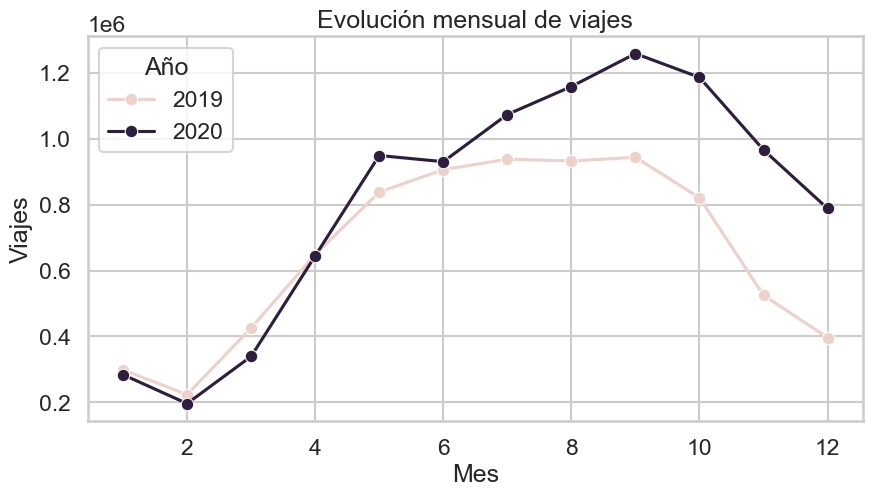

In [13]:
# 1. Evolución mensual (estacionalidad)
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly, x='month', y='trips', hue='year', marker='o')
plt.title("Evolución mensual de viajes")
plt.xlabel("Mes")
plt.ylabel("Viajes")
plt.legend(title='Año')

plt.savefig(os.path.join(output_dir, 'total-trips-evolution-year-over-year.png'))
plt.show()


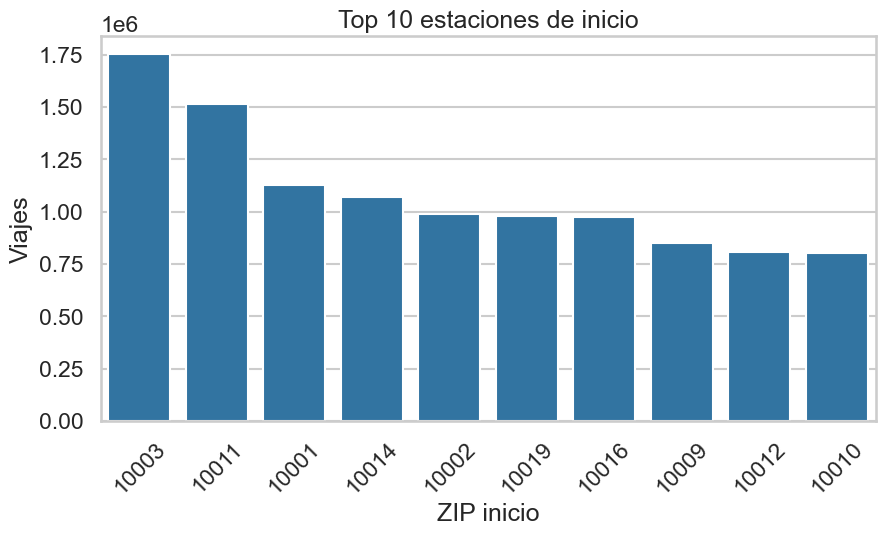

In [14]:
# 2. Top estaciones de inicio
top_start = (df_clean.groupby(['zip_code_start'])['trip_count'].sum()
             .sort_values(ascending=False).head(10)).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=top_start, x='zip_code_start', y='trip_count', color="#1f77b4", order=top_start['zip_code_start'])
plt.title("Top 10 estaciones de inicio")
plt.xlabel("ZIP inicio")
plt.ylabel("Viajes")
plt.xticks(rotation=45)

plt.savefig(os.path.join(output_dir, 'barchart-top-ten-starting-stations-by-zip.png'))
plt.show()


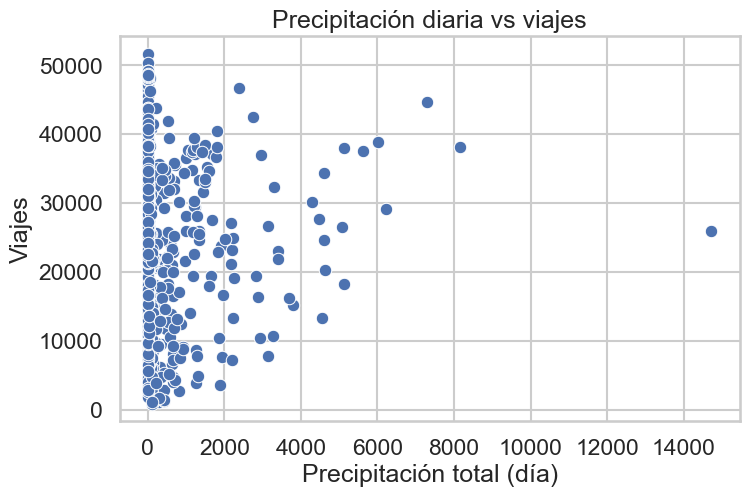

In [15]:

# 3. Clima vs viajes (scatter de precipitación)
plt.figure(figsize=(8,5))
sns.scatterplot(data=daily, x='total_precip', y='trips')
plt.title("Precipitación diaria vs viajes")
plt.xlabel("Precipitación total (día)")
plt.ylabel("Viajes")

plt.savefig(os.path.join(output_dir, 'scatter-daily-precipitation-vs-trips.png'))
plt.show()

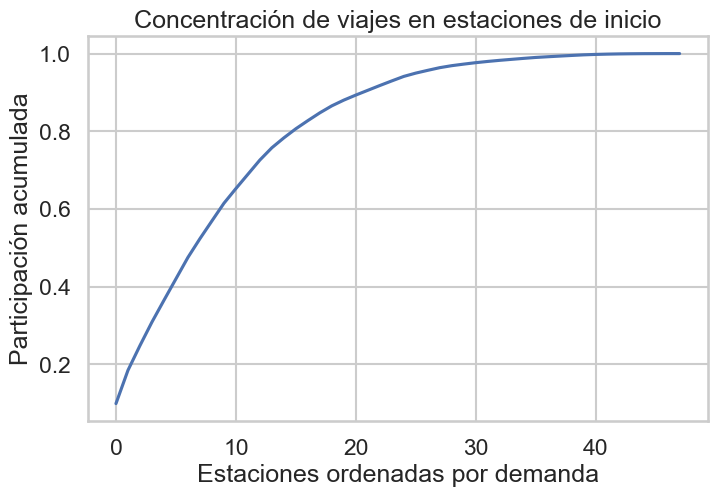

In [16]:
# 4. Concentración (curva acumulada Pareto)
plt.figure(figsize=(8,5))
sns.lineplot(data=start_conc.reset_index(), x=start_conc.reset_index().index, y='cum_share')
plt.title("Concentración de viajes en estaciones de inicio")
plt.xlabel("Estaciones ordenadas por demanda")
plt.ylabel("Participación acumulada")

plt.savefig(os.path.join(output_dir, 'pareto-total-trips-by-starting-stations.png'))

plt.show()

In [ ]:
# Guarda el DataFrame 'df_clean' en un archivo CSV
df_clean.to_csv('..\\google-bi-capstone\\data\\processed\\cyclistic-fact-processed.csv', index=False)